In [1]:
import requests
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

Fetch data from the [COVID-19 Tracking API](https://covidtracking.com)

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
r.status_code

200

In [3]:
state_daily_df = pd.DataFrame.from_dict(r.json())
state_daily_df['timestamp'] = pd.to_datetime(state_daily_df['date'], format='%Y%m%d')

state_daily_df['date'] = state_daily_df['timestamp'].apply(lambda x: f'{x.month}-{x.day}')

# Drop certain territories for now 
state_daily_df = state_daily_df[~state_daily_df['state'].isin(['AS', 'MP'])]

state_daily_df = state_daily_df.sort_values(['state']).reset_index(drop=True)
state_daily_df.head()

,date,state,positive,negative,pending,death,total,dateChecked,timestamp
0,3-17,AK,3.0,334.0,NaN,NaN,337.0,2020-03-17T20:00:00Z,2020-03-17
1,3-14,AK,1.0,143.0,NaN,NaN,144.0,2020-03-14T20:00:00Z,2020-03-14
2,3-13,AK,1.0,59.0,NaN,NaN,60.0,2020-03-13T20:00:00Z,2020-03-13
3,3-12,AK,0.0,46.0,14.0,NaN,60.0,2020-03-12T20:00:00Z,2020-03-12
4,3-11,AK,0.0,46.0,14.0,NaN,60.0,2020-03-11T20:00:00Z,2020-03-11


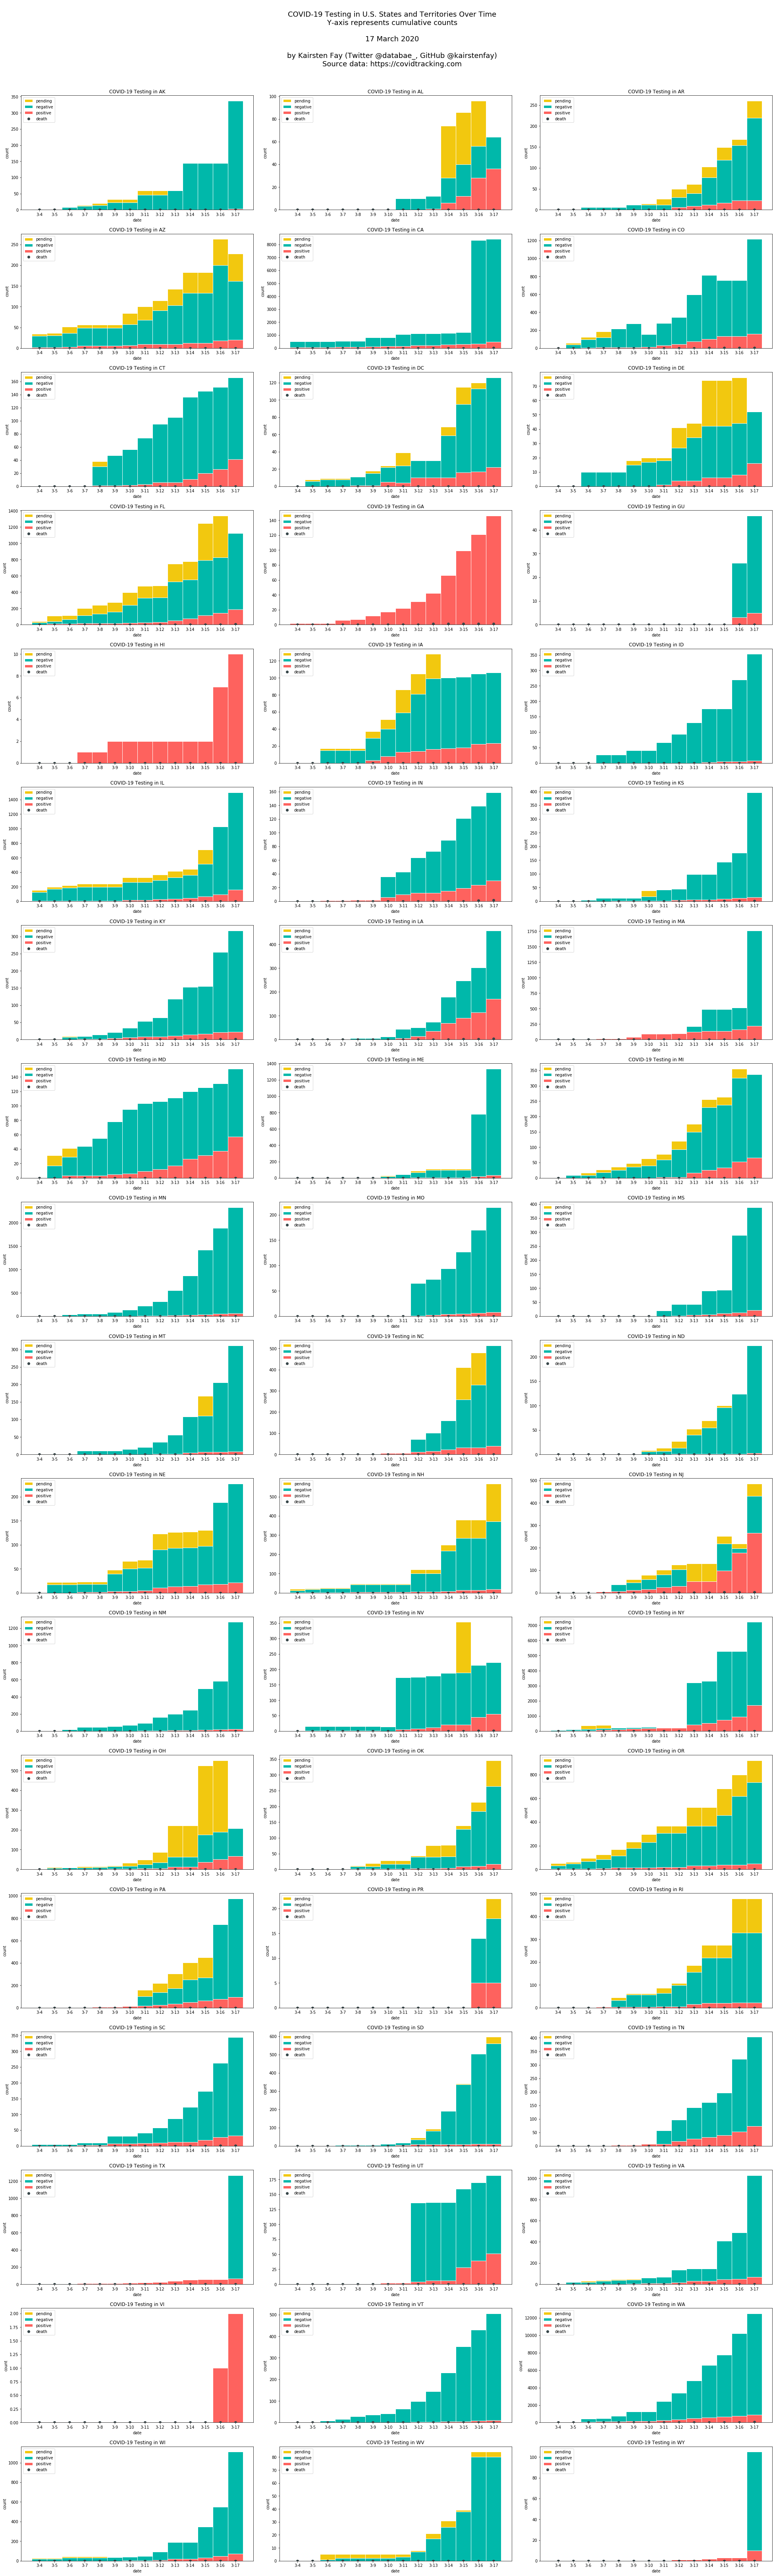

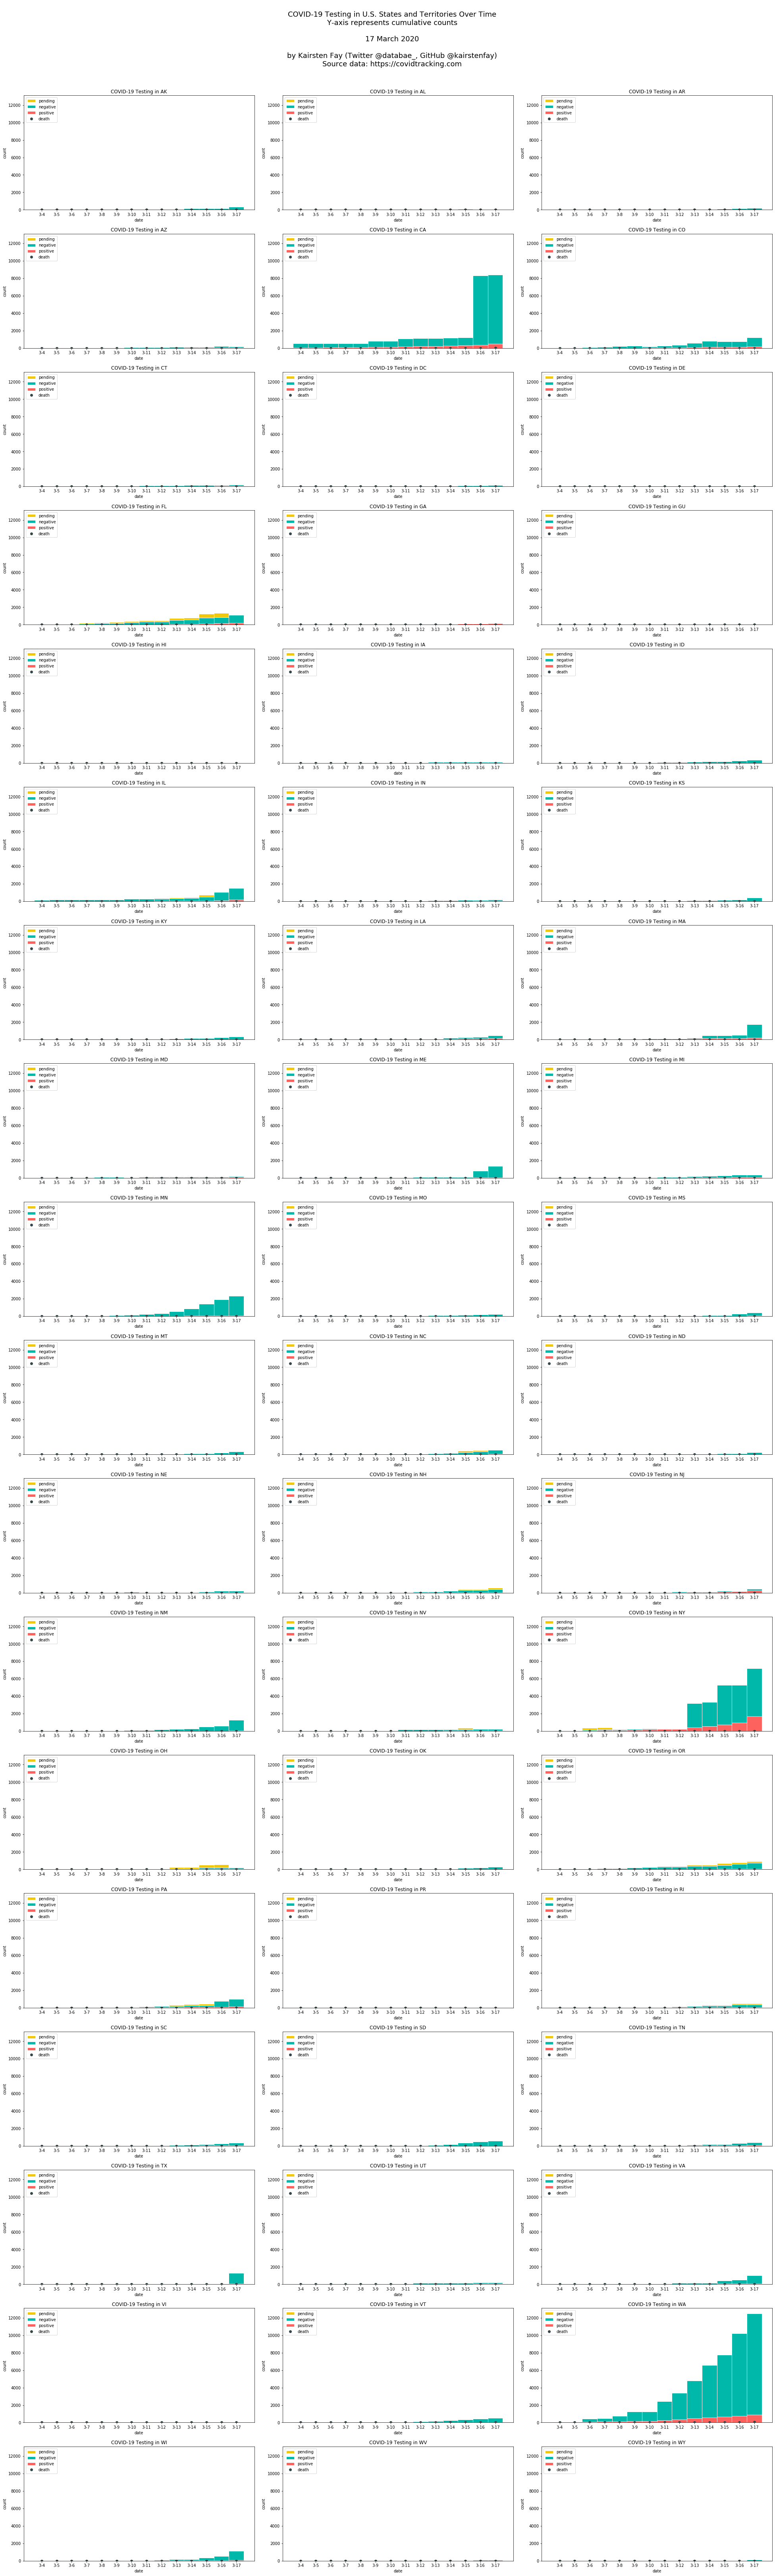

In [5]:
def print_stacked_barcharts(df: pd.DataFrame, output: str, 
                            sharex: bool=True, sharey: bool=False,
                            number_columns: int=3, 
                            max_states: int=101):
    """
    Use a low integer for *max_states* in local development to reduce graph generation time. 
    """
    def add_state(df: pd.DataFrame, states: list, state_index: int, number_columns: int, 
                  sharex: bool, sharey: bool): 
        """ """
        df = df.sort_values('timestamp')
        if state_index >= len(states): 
            return 
        
        state_df = df[df['state'] == states[state_index]]
        
        # Debugging shared x axes tick labels is too annoying. 
        # Use these date label data to filling missing state data with pd.NA
        date_labels = df[['date']].drop_duplicates()
        state_df = date_labels \
                        .merge(state_df, on='date', how='left') \
                        .replace({pd.NA: 0})

        column = state_index % number_columns
        add_bars(state_df, ax, column)
        
        if sharey:
            y_max = max(df['total'])
            ax[column].tick_params(labelleft=True)
        else:
            y_max = max(state_df['total'])

        # Set arbitrary buffer white space at top of bars 
        ax[column].set_ylim([0, y_max * 1.05])
    
#         if sharex:
#             # Improve readability between charts with better, explicit labeling
#             ax[column].set_xticks(list(range(len(date_labels))))
#             ax[column].set_xticklabels(df['date'].unique())
#             ax[column].tick_params(labelbottom=True, labelleft=True, labelrotation=0)

        ax[column].set_xlabel("date")
        ax[column].set_ylabel("count")
        ax[column].set_title(f"COVID-19 Testing in {states[state_index]}")
        
        # Place legend. Reverse handles and labels
        handles, labels = ax[column].get_legend_handles_labels()
        ax[column].legend(handles[::-1], labels[::-1], loc="upper left")

    def add_bars(state_df: pd.DataFrame, ax, column: int): 
        """ """
        edge_color = 'white'
        width = 1
        
        bars = {
            'positive': {
                'color': '#fe625e',
            },
            'negative': {
                'color': '#00b8aa',
            },
            'pending': {
                'color': '#f2c80f',
            },
        }
        
        circles = {
            'death': {
                'color': '#374649',
            },
        }
        
        cum_sum = [0] * len(state_df['date'])
    
        for bar_type in bars: 
            bars[bar_type]['bottom_height'] = cum_sum
            cum_sum = np.add(cum_sum, list(state_df[bar_type]))
            
            ax[column].bar(state_df['date'],
                           state_df[bar_type], 
                           label=bar_type,
                           tick_label=state_df['date'],
                           bottom=bars[bar_type]['bottom_height'], 
                           color=bars[bar_type]['color'], 
                           edgecolor=edge_color, 
                           width=width)
            
        for circle_type in circles: 
            ax[column].plot(state_df['date'],
                            state_df[circle_type],
                            'o', 
                            label=circle_type,
                            color=circles[circle_type]['color'])
    
    states = state_daily_df['state'].unique()
    number_states = min(len(states), max_states)
    number_rows = math.ceil(number_states / number_columns)

    fig, axs = plt.subplots(number_rows, number_columns, 
                            figsize=((9 * number_columns), (5 * number_states / number_columns)), 
                            constrained_layout=True, 
                            sharex=sharex, sharey=sharey)
    
    # Where `x` in `every_x_state_index` = number of columns
    every_x_state_index = range(number_states)[::number_columns]
        
    for ax, state_index in zip(axs, every_x_state_index):
        for i in range(number_columns):
            add_state(df, states, state_index + i, number_columns, sharex, sharey) 
    
    fig.suptitle("""
    COVID-19 Testing in U.S. States and Territories Over Time
    Y-axis represents cumulative counts

    17 March 2020

    by Kairsten Fay (Twitter @databae_, GitHub @kairstenfay)
    Source data: https://covidtracking.com

    """,
        fontsize=18)
    
    plt.savefig(output)

# TODO sharex is turned off for being too annoying. It's manually overridden 
# TODO also state limit doesn't work as expected
print_stacked_barcharts(state_daily_df, 'states_daily_data.png', sharex=False)
print_stacked_barcharts(state_daily_df, 'states_daily_data_shared_y.png', sharex=False, sharey=True)